# start

In [1]:

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmocean.cm as cmo
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.colors as cl

def rolling_(df):
    lol=pd.DataFrame(df).interpolate(limit=5, axis=1).interpolate(limit=5, axis=0).rolling(1, center=True, axis=1).mean()
    return lol.to_numpy()


def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return rolling_(grid),XI.T,YI.T

def grid_(df, variable, taxis_, yaxis_):
    sig, xx, yy=grid2d(df.time.values, df.pressure.values, df[variable].values, xi=taxis_, yi=yaxis_)
    # sig=rolling_(sig)
    return sig, xx, yy

import gsw
ds_bath=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2024_n35.0_s-10.0_w25.0_e85.0.nc')

# Floats IN NAS

In [2]:
# df_arg=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/argo_wwl_0_261floats_good_noroll.nc')
df_arg=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/argo_wwl_per_yr/L0/argo_wwl_0_578floats.nc')

# df_argbgc=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/bgq_argo_wwl_0_29floats.nc')
# df_arg.platform_num==df_argbgc.platform_num ## TRUE all bgc are in arg

def center_properties(dff,variablee):
    dff['core_'+variablee]=dff[variablee].sel(pressure_f=dff.min_n2_depth_f.fillna(0))*((dff.min_n2_depth_f/dff.min_n2_depth_f))

for i in list(df_arg.variables):
    df_arg=df_arg.rename({i:i+'_f'})
    
df_arg=df_arg.rename({'N2_f':'n2_f','N2_roll_f':'n2_roll_f', 'min_n2_f':'min_n2_depth_f'})

In [3]:
ds_interp=xr.open_dataset("/home/jupyter-estelfont/datasets/argo/datasets/ds_interp_1000m_2m.nc")

In [4]:
GS=0.5

def grid_lat_4d_count(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).count(dim='profile_num')#m

def grid_lon_4d_count(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)
    
    return dsgpd_t.groupby_bins('longitude',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_4d_count)

def grid_var_4d_count(dsvar,clim='month',gs=GS):
    """for gridding spatially in 3D and in time (4D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_4d_count)
    else:
        var = dsvar.groupby('time.'+clim).apply(grid_lon_4d_count)
    return var


lat_axis=np.arange(-5+GS/2,30+GS/2,GS)  ## assign the point to center of gridcell!
lon_axis=np.arange(30+GS/2,80+GS/2,GS)
yaxis=np.arange(0,1002,2)

profile_c=grid_var_4d_count(ds_interp['profile_num'])
profile_c=profile_c.rename('profile_count')

#### Plot

In [5]:
from matplotlib.gridspec import GridSpec
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
alp=0.5

In [6]:
N=440

In [8]:
def get_time_formation(df_arg, float_f):
    # lol=df_arg['density_MW'+float_f].bfill('time'+float_f).diff('time'+float_f)
    lol=df_arg['density_MW'+float_f].fillna(0).diff('time'+float_f)
    lol2=lol.where(np.abs(lol) > 0, drop=True)
    times=lol2['time'+float_f].values
    return times

def check_threshold_and_following_pointsMAX(series, threshold, float_f):
    if float_f=='_f':
        validityrange=2
    else:
        validityrange=8*4
    passed_threshold_index = None
    # Iterate through the time series data
    for i in range(len(series)):
        if series[i] > threshold:
            # Check if the last 5 points after passing the threshold remain above it
            if all(value >= threshold for value in series[i:i+validityrange]):
                passed_threshold_index = i
                break  # Stop iteration once the condition is met

    return passed_threshold_index

def check_threshold_and_following_pointsMIN(series, threshold, float_f): #8*4, 2
    if float_f=='_f':
        validityrange=2
    else:
        validityrange=8*4
    passed_threshold_index = None
    # Iterate through the time series data
    for i in range(len(series)):
        if series[i] < threshold:
            # Check if the last 5 points after passing the threshold remain above it
            if all(value <= threshold for value in series[i:i+validityrange]):
                passed_threshold_index = i
                break  # Stop iteration once the condition is met

    return passed_threshold_index

def get_time_formation_min_and_erosion(df_arg, float_f):
    center_properties(df_arg,'n2_f')
    
    ind_st=[[df_arg['time'+float_f][0].values,df_arg['time'+float_f][0].values, df_arg['time'+float_f][0].values]]
    if len(get_time_formation(df_arg, float_f))<1:
        ind_st=[[df_arg['time'+float_f][0].values,df_arg['time'+float_f][0].values, df_arg['time'+float_f][0].values]]

    elif len(get_time_formation(df_arg, float_f))<2:
        if float_f=='_f':
            dff=df_arg['core_n2'+float_f].rolling(time_f=1, center=True).median().ffill('time_f').sel(time_f=slice(get_time_formation(df_arg, float_f)[0],df_arg['time_f'][-1] )).bfill('time_f')                 
        else:
            dff=df_arg['core_n2'+float_f].rolling(time=1, center=True).median().ffill('time').sel(time=slice(get_time_formation(df_arg, float_f)[0], df_arg['time'][-1])).bfill('time')                    

        index_min=check_threshold_and_following_pointsMIN(dff, 0.00005,float_f)
        if index_min==None:
            index_min=0
            # index_max=0
            if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)==None:
                index_max=index_min
            else:
                index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)+index_min
            
        else: 
            if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)==None:
                index_max=index_min
            else:
                index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)+index_min

            if float_f=='_f':
                ind_st=[[get_time_formation(df_arg, '_f')[0], dff.time_f[index_min].values, dff.time_f[index_max].values]]
            else:
                ind_st=[[get_time_formation(df_arg, '')[0], dff.time[index_min].values, dff.time[index_max].values]]

        
    else:
        ind_st=[]
        for inddst in range(len(get_time_formation(df_arg, float_f))-1):
            if float_f=='_f':
                dff=df_arg['core_n2'+float_f].rolling(time_f=1, center=True).median().ffill('time_f').sel(time_f=slice(get_time_formation(df_arg, float_f)[inddst], get_time_formation(df_arg, float_f)[inddst+1])).bfill('time_f')                    
            else:
                dff=df_arg['core_n2'+float_f].rolling(time=1, center=True).median().ffill('time').sel(time=slice(get_time_formation(df_arg, float_f)[inddst], get_time_formation(df_arg, float_f)[inddst+1])).bfill('time')             

            index_min=check_threshold_and_following_pointsMIN(dff, 0.00005,float_f)
            # print(index_min)
            if index_min==None:
                index_min=0
                # index_max=0
                if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)==None:
                    index_max=index_min
                else:
                    index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)+index_min
                
            else: 
                # print(index_min)
                if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)==None:
                    index_max=index_min
                else:
                    index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)+index_min

            if float_f=='_f':
                ind_st.append([get_time_formation(df_arg, '_f')[inddst], dff.time_f[index_min].values, dff.time_f[index_max].values])
            else:
                ind_st.append([get_time_formation(df_arg, '')[inddst], dff.time[index_min].values, dff.time[index_max].values])
            
            
        inddst=len(get_time_formation(df_arg, float_f))-1
        if float_f=='_f':
            dff=df_arg['core_n2'+float_f].rolling(time_f=1, center=True).median().ffill('time_f').sel(time_f=slice(get_time_formation(df_arg, float_f)[inddst], df_arg['time_f'][-1] )).bfill('time_f')                       
        else:
            dff=df_arg['core_n2'+float_f].rolling(time=1, center=True).median().ffill('time').sel(time=slice(get_time_formation(df_arg, float_f)[inddst], df_arg['time'][-1] )).bfill('time')                
        
        index_min=check_threshold_and_following_pointsMIN(dff, 0.00005,float_f)
        # print(index_min)
        if index_min==None:
            index_min=0
            # index_max=0
            if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)==None:
                index_max=index_min
            else:
                index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)+index_min
        else: 
            # print(index_min)
            if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)==None:
                index_max=index_min
            else:
                index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005, float_f)+index_min
        if float_f=='_f':
            ind_st.append([get_time_formation(df_arg, '_f')[inddst], dff.time_f[index_min].values, dff.time_f[index_max].values])
        else:
            ind_st.append([get_time_formation(df_arg, '')[inddst], dff.time[index_min].values, dff.time[index_max].values])
            
    return ind_st


def _set_presence_mwl(df_plot_):
    msk = df_plot_.mixed_layer_depth_f.isnull().values.astype(float)
    msk[msk==1]=np.nan
    msk[msk==0]=1

    df_plot_['presence_mwl_f']=df_plot_.min_n2_depth_f.copy()*np.nan
    dss=pd.DataFrame(get_time_formation_min_and_erosion(df_plot_, '_f'))
    df_plot_['presence_mwl_f'].loc[dict(time_f=dss[0].to_numpy())]=0 # formation
    df_plot_['presence_mwl_f'].loc[dict(time_f=dss[1].to_numpy())]=1  # min
    df_plot_['presence_mwl_f'].loc[dict(time_f=dss[2].to_numpy())]=2 # erosiom
    df_plot_['presence_mwl_f']=df_plot_['presence_mwl_f'].ffill('time_f')
    df_plot_['presence_mwl_f']= df_plot_['presence_mwl_f']*msk

In [9]:
def plt_lines(df_plt):

    plt.plot(df_plt.time_f,df_plt.bot_mwl_f, c='gray')
    plt.plot(df_plt.time_f,df_plt.top_mwl_f, c='gray', ls='--')
    plt.plot(df_plt.time_f,df_plt.min_n2_depth_f, c='olive', alpha=0.5)
    plt.plot(df_plt.time_f,df_plt.mwd_f, c='b', ls=':')
    plt.plot(df_plt.time_f,df_plt.mixed_layer_depth_f, c='b')

    
    msk=(df_plt.presence_mwl_f<2).astype(float)
    msk=msk.where(msk!=0, np.nan)
    df_plt['mw_thickness']=df_plt.bot_mwl_f-df_plt.top_mwl_f

    msk_thickness=(df_plt.mw_thickness>10).astype(float)
    msk_thickness=msk_thickness.where(msk_thickness!=0, np.nan)
    
    plt.plot(df_plt.time_f,msk_thickness*msk*df_plt.bot_mwl_f.values, c='k')
    plt.plot(df_plt.time_f, msk_thickness*msk*df_plt.top_mwl_f.values, c='k',ls='--')    
    plt.plot(df_plt.time_f, msk_thickness*msk*df_plt.min_n2_depth_f.values, c='g')    

In [10]:
df_fN=df_arg.sel(platform_num_f=6903059.)
df_fS=df_arg.sel(platform_num_f=2901857.)

_set_presence_mwl(df_fN)
_set_presence_mwl(df_fS)

In [11]:
# AVERAGE PROFILES PER BIN!
df=pd.DataFrame(profile_c.sum(dim='month').values.flatten())

np.nanmean(df.loc[~(df==0).all(axis=1)][0])

30.77912019826518

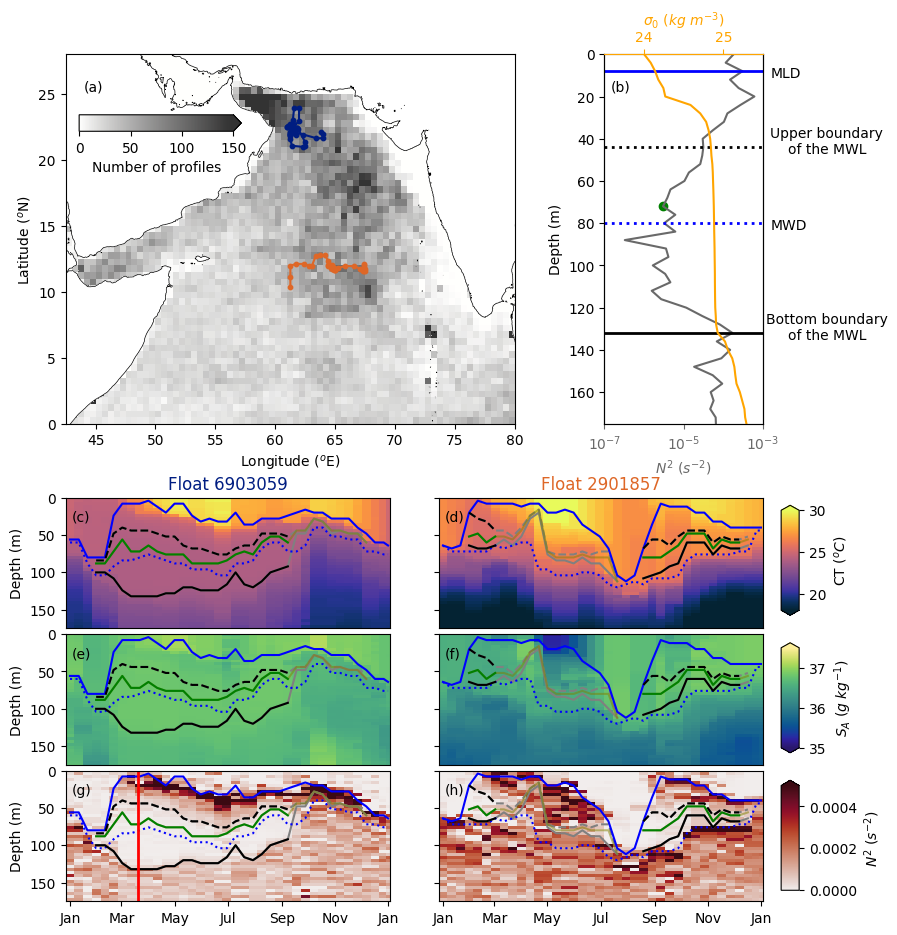

In [12]:
# df_fN=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/pwp_output/pwp_vs_obs_float_258.nc')
yrN, yrS=2022, 2018
# cn, cs=["#920048","#94ba2e"]
cn, cs=["#001d81",
"#de6727"]
gs = GridSpec(11+14, 17)
fig = plt.figure(figsize=(9,11))


ax1 = fig.add_subplot(gs[:11, :11])
t=ax1.text(x=.04,y=.9,s="(a)",transform=ax1.transAxes)
# t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

cc=plt.pcolormesh(lon_axis, lat_axis, profile_c.sum(dim='month').T, vmin=0, vmax=150, cmap=cmo.gray_r, alpha=0.8)
# cc=plt.pcolormesh(lon_axis, lat_axis, profile_c.sum(dim='month').T, norm=LogNorm(vmin=10, vmax=200), cmap=cmo.gray_r, alpha=0.8)
# plt.contourf(ds_bath.lon[::50],ds_bath.lat[::50], ds_bath.elevation[::50, ::50],  levels=[-1,3000], colors='#edede9')
plt.contourf(ds_bath.lon[::10],ds_bath.lat[::10], ds_bath.elevation[::10, ::10],  levels=[-1, 3000], colors='w')
plt.contour(ds_bath.lon[::10],ds_bath.lat[::10], ds_bath.elevation[::10, ::10],  levels=[-1], linewidths=0.5,colors='k', linestyles='-')

plt.ylim(0,28)
plt.xlim(42.5,80)
dss_=df_fN.sel(time_f=slice(pd.to_datetime(str(yrN)), pd.to_datetime(str(yrN+1)))) 
# plt.scatter(df_fN.longitude_f.mean('pressure_f'), df_fN.latitude_f.mean('pressure_f'), c=cn, s=10, alpha=0.2, zorder=10)
plt.scatter(dss_.longitude_f.mean('pressure_f'), dss_.latitude_f.mean('pressure_f'), c=cn, s=10, zorder=10)
plt.plot(dss_.longitude_f.mean('pressure_f'), dss_.latitude_f.mean('pressure_f'), lw=1.5, c=cn)

dss_=df_fS.sel(time_f=slice(pd.to_datetime(str(yrS)), pd.to_datetime(str(yrS+1)))) 
# plt.scatter(df_fS.longitude_f.mean('pressure_f'), df_fS.latitude_f.mean('pressure_f'), c=cs,edgecolor=None, s=10,alpha=0.2, zorder=10)
plt.scatter(dss_.longitude_f.mean('pressure_f'), dss_.latitude_f.mean('pressure_f'), c=cs, s=10, zorder=10)
plt.plot(dss_.longitude_f.mean('pressure_f'), dss_.latitude_f.mean('pressure_f'), lw=1.5, c=cs)

plt.ylabel('Latitude ($^o$N)')            
plt.xlabel('Longitude ($^o$E)')            
    
cbaxes = fig.add_axes([0.14, 0.81, 0.18, 0.015]) 
cbb=plt.colorbar(cc, cax=cbaxes, orientation='horizontal', extend= 'max')
cbb.set_label('Number of profiles')
# cbb.ax.tick_params(l-2)

# plt.colorbar(orientation='horizontal')
df_plt=df_fN.copy() #xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/pwp_output/pwp_vs_obs_float_143.nc')

# df_plt=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/pwp_output/pwp_vs_obs_float_258.nc')
df_plt=df_plt.sel(time_f=slice(pd.to_datetime('2022'), pd.to_datetime('2023')))

topp=13
ax2 = fig.add_subplot(gs[topp:topp+4, 0:8])
plt.title('Float '+str(int(df_plt.platform_num_f)), color=cn)
t=ax2.text(x=.02,y=.82,s="(" + letters[2] + ')',transform=ax2.transAxes)
# t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
plt.pcolormesh(df_plt.time_f, df_plt.pressure_f, df_plt.cons_temp_f, vmin=18, vmax=30, cmap=cmo.thermal)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().axes.xaxis.set_ticklabels([])
plt.ylim(175,0)
plt.xticks([])

plt_lines(df_plt)
plt.ylabel('Depth (m)')


ax2 = fig.add_subplot(gs[topp+4:topp+8, 0:8])

t=ax2.text(x=.02,y=.82,s="(" + letters[4] + ')',transform=ax2.transAxes)
# t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
plt.pcolormesh(df_plt.time_f, df_plt.pressure_f, df_plt.abs_salinity_f, vmin=35, vmax=37.5, cmap=cmo.haline)
plt.ylim(175,0)
plt.xticks([])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().axes.xaxis.set_ticklabels([])
plt_lines(df_plt)
plt.ylabel('Depth (m)')


ax2 = fig.add_subplot(gs[topp+8:, 0:8])
t=ax2.text(x=.02,y=.82,s="(" + letters[6] + ')',transform=ax2.transAxes)
# t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
plt.pcolormesh(df_plt.time_f, df_plt.pressure_f, df_plt.n2_f, vmin=0, vmax=0.0005, cmap=cmo.amp)
plt.ylim(175,0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt_lines(df_plt)
# plt.xticks([])

plt.axvline(pd.to_datetime('2022-03-20'), c='r', lw=2)
plt.ylabel('Depth (m)')


df_plt=df_fS.copy() #xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/pwp_output/pwp_vs_obs_float_143.nc')
df_plt=df_plt.sel(time_f=slice(pd.to_datetime('2018'), pd.to_datetime('2019')))

ax2 = fig.add_subplot(gs[topp:topp+4, 9:])
plt.title('Float '+str(int(df_plt.platform_num_f)), color=cs)

t=ax2.text(x=.02,y=.82,s="(" + letters[3] + ')',transform=ax2.transAxes)
# t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
cct=plt.pcolormesh(df_plt.time_f, df_plt.pressure_f, df_plt.cons_temp_f, vmin=18, vmax=30, cmap=cmo.thermal)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().axes.xaxis.set_ticklabels([])
plt.ylim(175,0)
plt_lines(df_plt)
plt.gca().axes.yaxis.set_ticklabels([])
plt.xticks([])


ax2 = fig.add_subplot(gs[topp+4:topp+8, 9:])
t=ax2.text(x=.02,y=.82,s="(" + letters[5] + ')',transform=ax2.transAxes)
# t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
ccs=plt.pcolormesh(df_plt.time_f, df_plt.pressure_f, df_plt.abs_salinity_f, vmin=35, vmax=37.5, cmap=cmo.haline)
plt.ylim(175,0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().axes.xaxis.set_ticklabels([])
plt.xticks([])
plt_lines(df_plt)
plt.gca().axes.yaxis.set_ticklabels([])


ax2 = fig.add_subplot(gs[topp+8:, 9:])
t=ax2.text(x=.02,y=.82,s="(" + letters[7] + ')',transform=ax2.transAxes)
# t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
ccn=plt.pcolormesh(df_plt.time_f, df_plt.pressure_f, df_plt.n2_f, vmin=0, vmax=0.0005, cmap=cmo.amp)
plt.ylim(175,0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt_lines(df_plt)
plt.gca().axes.yaxis.set_ticklabels([])


ax2 = fig.add_subplot(gs[:11, 13:])

df_plt=df_fN.copy() #xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/pwp_output/pwp_vs_obs_float_258.nc')
df_plt=df_plt.sel(time_f=slice(pd.to_datetime('2022'), pd.to_datetime('2023')))

t=ax2.text(x=.04,y=.9,s="(b)",transform=ax2.transAxes)
# t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
        

dff_prof=df_plt.sel(time_f=pd.to_datetime('2022-03-20'), method='nearest')
# plt.figure(figsize=(3,4))

plt.plot(np.abs(dff_prof.n2_roll_f[:]),  dff_prof.pressure_f, c='dimgrey')
# plt.plot(np.abs(dff_prof.n2_f[:]),  dff_prof.pressure_f, c='gray', alpha=0.5)

# plt.xlim(0,0.1e6)
# plt.axvline(0, c='gray')
plt.xscale('log')
plt.ylabel('Depth (m)')

plt.axhline(dff_prof.mixed_layer_depth_f, c='b', lw=2)
plt.axhline(dff_prof.mwd_f, c='b', ls=':', lw=2)
# plt.axhline(float_.mwd[N]-4, c='b')
plt.xlabel('$N^2$ ($s^{-2}$)', color='dimgrey')

plt.axhline(dff_prof.top_mwl_f, c='k', ls=':', lw=2)

plt.text(4e-2, dff_prof.top_mwl_f+3, s='Upper boundary\nof the MWL', horizontalalignment='center',)
plt.text(4e-2, dff_prof.bot_mwl_f+3, s='Bottom boundary\nof the MWL', horizontalalignment='center',)
plt.text(1.5e-3, dff_prof.mixed_layer_depth_f+3, s='MLD')
plt.text(1.5e-3, dff_prof.mwd_f+3, s='MWD')

plt.axhline(dff_prof.bot_mwl_f, c='k', lw=2)
plt.scatter(np.abs(dff_prof.n2_roll_f.sel(pressure_f= dff_prof.min_n2_depth_f.values).values), dff_prof.min_n2_depth_f, c='g')
ax2.spines['bottom'].set_color('dimgrey')
ax2.tick_params(axis='x', colors='dimgrey')
ax2.set_xlim(1e-7, 1e-3)

ax=plt.twiny()
ax.plot(dff_prof.potential_density_f, dff_prof.pressure_f, c='orange')
# for i in np.arange(24.8,25.3, 0.05):
#     plt.axvline(i, alpha=0.5)
ax.set_xlabel('$\sigma_0$ ($kg$ $m^{-3}$)', color='orange')
# ax.spines['bottom'].set_color('red')
ax.spines['top'].set_color('orange')
# ax.xaxis.label.set_color('red')
ax.tick_params(axis='x', colors='orange')
ax.set_xlim(23.5, 25.5)
plt.ylim(175,0)

cbaxes = fig.add_axes([0.92, 0.37, 0.02, 0.1]) 
cbb=plt.colorbar(cct, cax=cbaxes, extend= 'both')
cbb.set_label('CT ($^oC$)')
# cbb.ax.tick_params(l-2)
cbaxes = fig.add_axes([0.92, 0.245, 0.02, 0.1]) 
cbb=plt.colorbar(ccs, cax=cbaxes,  extend= 'both')
cbb.set_label('$S_A$ ($g$ $kg^{-1}$)')
# cbb.ax.tick_params(l-2)
cbaxes = fig.add_axes([0.92, 0.12, 0.02, 0.1]) 
cbb=plt.colorbar(ccn, cax=cbaxes,  extend= 'max')
cbb.set_label('$N^2$ ($s^{-2}$)')
# cbb.ax.tick_params(l-2)

plt.savefig('Figures/Figure1_ASMW.png', dpi=600, bbox_inches='tight')

### FIGURE 2 - T_S mode water

In [14]:
dff_CT=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/all_ct_mw.nc')
dff_SA=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/all_sa_mw.nc')
dff_bot=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/bot_mw.nc')
dff_top=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/top_mw.nc')
dff_presence=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/presence_mw.nc')

lol2=((dff_bot.bot_mwl_f-dff_top.top_mwl_f)>10).astype(float).values
lol2[lol2==0]=np.nan

lol=(dff_presence.presence_mwl_f!=2).astype(float).values
lol[lol==0]=np.nan

dff_presence['presence_mwl_f_mask']=(('platform_num_f', 'time_f'), lol*lol2)

dff_CT['cons_temp_f_msk']=dff_CT.cons_temp_f*dff_presence['presence_mwl_f_mask']

In [15]:
dfsaa=dff_SA.abs_salinity_f.where((dff_SA.pressure_f>dff_top.top_mwl_f)&(dff_SA.pressure_f<dff_bot.bot_mwl_f)).mean('pressure_f')
dfctt=dff_CT.cons_temp_f_msk.where((dff_SA.pressure_f>dff_top.top_mwl_f)&(dff_SA.pressure_f<dff_bot.bot_mwl_f)).mean('pressure_f')


wint_ct=dfctt.groupby('time_f.season')['DJF']
spr_ct=dfctt.groupby('time_f.season')['MAM']
summ_ct=dfctt.groupby('time_f.season')['JJA']
fall_ct=dfctt.groupby('time_f.season')['SON']

wint_sa=dfsaa.groupby('time_f.season')['DJF']
spr_sa=dfsaa.groupby('time_f.season')['MAM']
summ_sa=dfsaa.groupby('time_f.season')['JJA']
fall_sa=dfsaa.groupby('time_f.season')['SON']



all_cts_mw=[wint_ct,spr_ct,summ_ct,fall_ct]
all_sas_mw=[wint_sa,spr_sa,summ_sa,fall_sa]


In [16]:
dflats=dff_CT.latitude_f.expand_dims(pressure_f=dff_CT.pressure_f, axis=1).where((dff_SA.pressure_f>dff_top.top_mwl_f)&(dff_SA.pressure_f<dff_bot.bot_mwl_f)).mean('pressure_f')

wint_lat=dflats.groupby('time_f.season')['DJF']
spr_lat=dflats.groupby('time_f.season')['MAM']
summ_lat=dflats.groupby('time_f.season')['JJA']
fall_lat=dflats.groupby('time_f.season')['SON']

all_lats_mw=[wint_lat,spr_lat,summ_lat,fall_lat]


In [17]:
from matplotlib.colors import LinearSegmentedColormap
# import cmocean

# Function to truncate a colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Truncate colormap to a specific range."""
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original colormap
original_cmap = cmo.ice_r

# Truncate the colormap to exclude the last 10%
truncated_cmap = truncate_colormap(original_cmap, minval=0.2, maxval=1)

  0%|          | 0/4 [00:00<?, ?it/s]

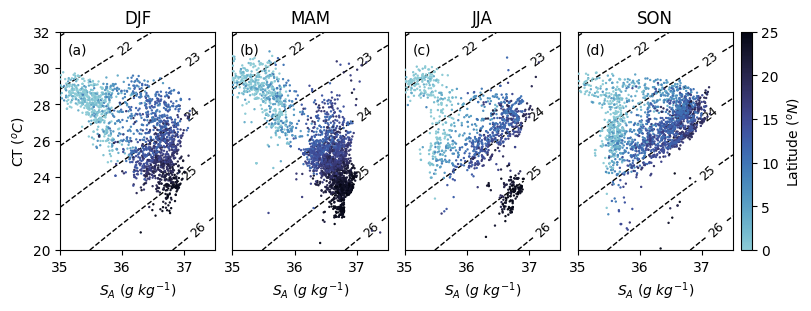

In [19]:
# Plotting T-S isolines of PGW and potential density
fnt=10
def ts_ax(ax, fns):
    limto=4
    mins,maxs=35, 37.5
    mint,maxt=20, 32
    tempL,salL=np.linspace(mint,maxt,1000), np.linspace(mins,maxs,1000)
    Wg, Qg = np.meshgrid(tempL,salL)
    
    sig = gsw.sigma0(Qg, Wg)
    
    CS=ax.contour(Qg, Wg, sig, colors='k', linestyles='dashed', linewidths=1, levels=np.arange(18,37,1))
    ax.clabel(CS, fontsize=fns-1, inline=1, fmt='%1.0f')
    
#     sig = gsw.spiciness0(Qg, Wg)
    
#     CS=ax.contour(Qg, Wg, sig, colors='g', linestyles='dashed', linewidths=1, levels=np.arange(1,9, 1))
#     ax.clabel(CS, fontsize=fns-1, inline=1, fmt='%1.0f')
    # ax.set_xlabel('Absolute salinity ($g$ $kg^{-1}$)', fontsize=fns)
    # ax.set_xticks([33, 34, 35,36,37,38,39])
    ax.set_xlim(35, 37.5)
    ax.set_ylim(20, 32)
    return

letters=['a', 'b','c', 'd']
season=['DJF', 'MAM', 'JJA', 'SON']
fig = plt.figure(figsize=(8, 3), constrained_layout=True)

for i in tqdm(range(4)):
    ax1=plt.subplot(141+i)
    t=ax1.text(x=.05,y=.90,s='('+letters[i]+')',transform=ax1.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w'))
    ts_ax(ax1, fnt)
    plt.title(season[i])
    # ax1.scatter(all_sas[i].values.flatten(),all_cts[i].values.flatten(), s=0.1, alpha=0.4, c='gainsboro',  zorder=10)   
    
    cb=plt.scatter(all_sas_mw[i].values.flatten(), 
                all_cts_mw[i].values.flatten(), c=all_lats_mw[i].values.flatten(),
            zorder=20,alpha=1,s=0.5, vmin=0, vmax=25, cmap=truncated_cmap)
 
    # cb=plt.scatter(all_sas_mw_core[i].values.flatten(), 
    #                 all_cts_mw_core[i].values.flatten(), color='r',
    #             zorder=20,alpha=1,s=0.25)
 
    ax1.tick_params(axis='both')
    if (i==0):
        # ax1.set_xticks([])
        ax1.set_xlabel('$S_A$ ($g$ $kg^{-1}$)', fontsize=fnt)
        ax1.set_ylabel('CT ($^oC$)', fontsize=fnt)
        
    if (i==1):
        # ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_xlabel('$S_A$ ($g$ $kg^{-1}$)', fontsize=fnt)
    if (i==2):
        # ax1.set_xticks([])
        ax1.set_yticks([])
        # ax1.set_ylabel('Conservative temperature ($^oC$)', fontsize=fnt)
        ax1.set_xlabel('$S_A$ ($g$ $kg^{-1}$)', fontsize=fnt)
    elif (i==3):
        ax1.set_xlabel('$S_A$ ($g$ $kg^{-1}$)', fontsize=fnt)
        ax1.set_yticks([])


cb=plt.colorbar()
cb.set_label('Latitude ($^o N$)')
plt.savefig('Figures/Figure2_TS_coreMW_lat.png', dpi=600, bbox_inches='tight')

In [152]:
# # Plotting T-S isolines of PGW and potential density
# fnt=10
# def ts_ax(ax, fns):
#     limto=4
#     mins,maxs=35, 37.5
#     mint,maxt=20, 32
#     tempL,salL=np.linspace(mint,maxt,1000), np.linspace(mins,maxs,1000)
#     Wg, Qg = np.meshgrid(tempL,salL)
    
#     sig = gsw.sigma0(Qg, Wg)
    
#     CS=ax.contour(Qg, Wg, sig, colors='k', linestyles='dashed', linewidths=1, levels=np.arange(18,37,1))
#     ax.clabel(CS, fontsize=fns-1, inline=1, fmt='%1.0f')
    
#     sig = gsw.spiciness0(Qg, Wg)
    
#     CS=ax.contour(Qg, Wg, sig, colors='g', linestyles='dashed', linewidths=1, levels=np.arange(1,9, 1))
#     ax.clabel(CS, fontsize=fns-1, inline=1, fmt='%1.0f')
#     # ax.set_xlabel('Absolute salinity ($g$ $kg^{-1}$)', fontsize=fns)
#     # ax.set_xticks([33, 34, 35,36,37,38,39])
#     ax.set_xlim(35, 37.5)
#     ax.set_ylim(20, 32)
#     return

# letters=['a', 'b','c', 'd']
# season=['DJF', 'MAM', 'JJA', 'SON']
# fig = plt.figure(figsize=(10, 3), constrained_layout=True)

# for i in tqdm(range(1)):
#     ax1=plt.subplot(141+i)
#     t=ax1.text(x=.05,y=.90,s='('+letters[i]+')',transform=ax1.transAxes)
#     t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w'))
#     ts_ax(ax1, fnt)
#     plt.title(season[i])
#     # ax1.scatter(all_sas[i].values.flatten(),all_cts[i].values.flatten(), s=0.1, alpha=0.4, c='gainsboro',  zorder=10)   
    
#     cb=plt.scatter(all_sas_mw[i].values.flatten(), 
#                 all_cts_mw[i].values.flatten(), c=all_lats_mw[i].values.flatten(),
#             zorder=20,alpha=1,s=0.25, vmin=0, vmax=25, cmap=cmo.ice)
 
#     # cb=plt.scatter(all_sas_mw_core[i].values.flatten(), 
#     #                 all_cts_mw_core[i].values.flatten(), color='r',
#     #             zorder=20,alpha=1,s=0.25)
 
#     ax1.tick_params(axis='both')
#     if (i==0):
#         # ax1.set_xticks([])
#         ax1.set_xlabel('Absolute salinity ($g$ $kg^{-1}$)', fontsize=fnt)
#         ax1.set_ylabel('Conservative temperature ($^oC$)', fontsize=fnt)
        
#     if (i==1):
#         # ax1.set_xticks([])
#         ax1.set_yticks([])
#         ax1.set_xlabel('Absolute salinity ($g$ $kg^{-1}$)', fontsize=fnt)
#     if (i==2):
#         # ax1.set_xticks([])
#         ax1.set_yticks([])
#         # ax1.set_ylabel('Conservative temperature ($^oC$)', fontsize=fnt)
#         ax1.set_xlabel('Absolute salinity ($g$ $kg^{-1}$)', fontsize=fnt)
#     elif (i==3):
#         ax1.set_xlabel('Absolute salinity ($g$ $kg^{-1}$)', fontsize=fnt)
#         ax1.set_yticks([])


# cb=plt.colorbar()
# cb.set_label('Latitude ($^o N$)')